In [1]:
import cf_xarray.units  # noqa: F401
import matplotlib.pyplot as plt
import pandas as pd
import pint
import pint_xarray  # noqa: F401
import plotly.express as px
import xarray as xr
from plotly import graph_objects as go

from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

## Commande

Paths :

```bash
SEAPODYM_EXECUTABLE = /Users/ash/Documents/Workspaces/Github/seapodym-project/seapodym-lmtl/build/bin/seapodym-lmtl

SEAPODYM_CONFIG_FILE = /Users/ash/Documents/Workspaces/Data/phd/SEAPODYM_LMTL/SEAPODYM_LMTL/configs/SEAPODYM_LMTL_D1N1.xml
```

Command :

```bash
mpirun -mca btl ^openib -np 6 "/Users/ash/Documents/Workspaces/Github/seapodym-project/seapodym-lmtl/build/bin/seapodym-lmtl" -P -G D1N1 -V error "/Users/ash/Documents/Workspaces/Data/phd/SEAPODYM_LMTL/2025-01-10_-_CAFE_HOT/zpk.tmpl.xml"
```


In [2]:
path_to_forcing = "../../../../../1_data_processing/1_1_Forcing/products/Hot_cmems.zarr"
path_to_product = "/Users/ash/Documents/Workspaces/Data/phd/SEAPODYM_LMTL/2025-01-10_-_CAFE_HOT/output"
path_to_obs = "../../../../../1_data_processing/1_1_Forcing/products/Hot_obs_filtered.zarr"
export_file_name = "SeapoDym_HOT_CAFE_by_epi_layer_depth"

In [3]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-01"
TIME_END = "2010-01-01"

## Loading


### Prediction


In [4]:
biomass = xr.open_mfdataset(path_to_product + "/*biomass*.nc", combine="by_coords")

In [ ]:
biomass = biomass.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
biomass = biomass.resample(time="1D").mean()
biomass = biomass.pint.quantify().pint.to("mg/m^2")
biomass = biomass.zpk_epi
biomass.load()

### Forcing


In [6]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[117.28651141881937 119.60032794934789 117.12780198170734 ... 126.24273554890118 127.85488930482899 128.32600573920374]
Units,meter


### Observations


In [7]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, layer=0, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations

<xarray.Dataset> Size: 8kB
Dimensions:    (time: 350)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1998-01-10 1998-01-11 ... 2022-09-01
    latitude   float64 8B [degrees_north] 22.75
    layer      int64 8B 0
    longitude  int64 8B [degrees_east] -158
    depth      int64 8B 0
Data variables:
    day        (time) float64 3kB [mg/m²] 90.15 102.1 131.0 ... 296.7 300.3
    night      (time) float64 3kB [mg/m²] 168.0 250.1 219.5 ... 536.3 319.2

## Plot


### Taylor Diagram


Convert to pandas series.


In [8]:
biomass_pandas = biomass.pint.dequantify().to_dataframe().reset_index().set_index("time")["zpk_epi"]
observations_day_pandas = (
    observations.pint.dequantify().day.dropna("time").to_dataframe().reset_index().set_index("time")["day"]
)
observations_night_pandas = (
    observations.pint.dequantify().night.dropna("time").to_dataframe().reset_index().set_index("time")["night"]
)
layer_pandas = epi_layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]

Then resample to month.


In [9]:
monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred = biomass_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred.index = monthly_pred.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

In [10]:
fig = go.Figure(
    layout={
        "title": f"SeapoDym Monthly Biomass  : {export_file_name}",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)


fig.add_trace(
    go.Scatter(
        x=monthly_obs_day.index,
        y=monthly_obs_day,
        fill=None,
        mode="lines",
        line={"color": "red", "width": 1},
        name="Observations (day)",
    )
)

fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        fill="tonexty",
        mode="lines",
        line={"color": "rgba(180, 180, 180, 0.2)", "width": 1},
        name="Observations (night)",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_pred.index,
        y=monthly_pred,
        fill=None,
        mode="lines",
        line={"color": "black"},
        name="Predictions",
    )
)
fig.add_trace(px.line(monthly_layer).data[0])
fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dash"},
)
fig.update_layout(yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"})

fig.show()

In [11]:
fig.write_html(f"Biomass_{export_file_name}.html")

correlation [0.5540630117439329, 0.38961950570295156]
norm STD [0.4861892264870018, 0.3851776600979914]
bias [0.3704248263348577, -0.9805184070578571]
NRMSE [0.8352371076972749, 0.9209866288812267]
name ['HOT Day', 'HOT Night']


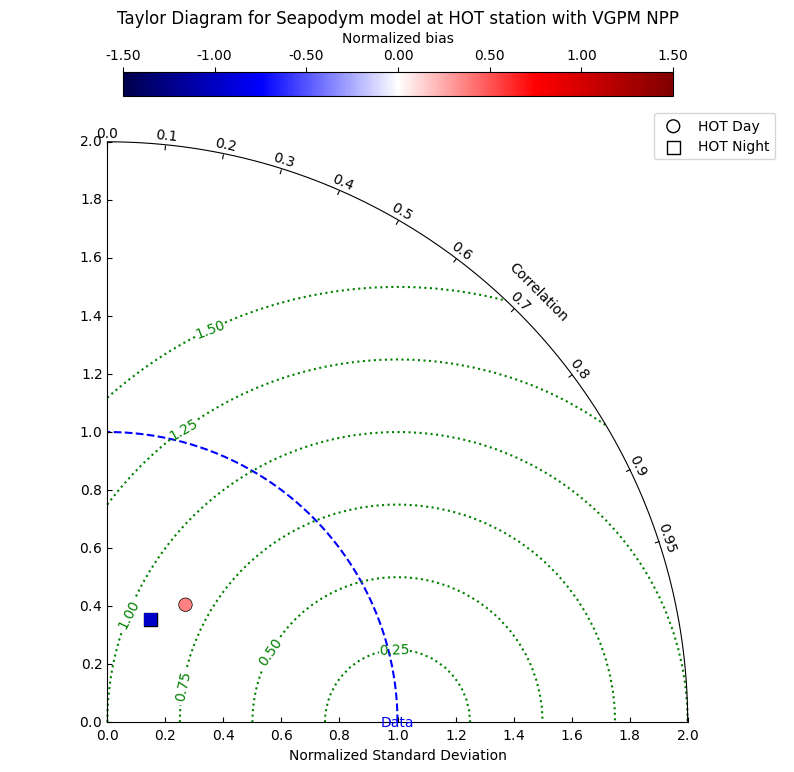

In [12]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred, monthly_pred]
all_obs = [monthly_obs_day, monthly_obs_night]

all_names = ["HOT Day", "HOT Night"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title(f"Taylor Diagram for Seapodym model  : {export_file_name}")

# export the figure
plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [13]:
diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,HOT Day,0.554063,0.486189,0.370425,0.835237
1,HOT Night,0.389620,0.385178,-0.980518,0.920987
